# Soft Pseudo-labels

In [1]:
! rsync -a /kaggle/input/mmdetection-v280/mmdetection /
! pip install /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
! pip install /kaggle/input/hpapytorchzoo/pytorch_zoo-master/
! pip install /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation/
! pip install /kaggle/input/iterative-stratification/iterative-stratification-master/

! cp -r /kaggle/input/kgl-humanprotein-data/kgl_humanprotein_data /
! cp -r /kaggle/input/humanpro/kgl_humanprotein /

import sys
sys.path.append('/kgl_humanprotein/')

Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272891 sha256=23c1582f8f045cff4322f46f3eb8a1c3d3d4ccfc0360d71dcff51a1ad0497177
  Stored in directory: /root/.cache/pip/wheels/80/e0/da/3288fdf3965b5c9090f368462db9d28be2c82013f51821090a
Successfully built mmpycocotools
Processing /kaggle/input/hpapytorchzoo/pytorch_zoo-master
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=ab9c3abdfea249ddf0ac1eae913d9542aa1c8b1eed5eca81b299e591e63e71cc
  Stored in directory: /root/.cache/pip/wheels/7f/18/21/aff5a8914e22461b2b025a9629c2b70464c36183caaf12bc09
Successfully built pytorch-zoo
Processing /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14815 sha256=94c97f4bbbfe1d5a309feca18771190dd9766277f32a5413a8a41c3f465e90b1
  Stored in di

In [2]:
import os
import time
from pathlib import Path
import shutil
import zipfile
import functools
import multiprocessing
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import KFold,StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
from torch.backends import cudnn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import DataParallel
import matplotlib.pyplot as plt
from tqdm import tqdm

from kgl_humanprotein.utils.common_util import *
from kgl_humanprotein.config.config import *
from kgl_humanprotein.data_process import *
from kgl_humanprotein.datasets.tool import image_to_tensor
from kgl_humanprotein.datasets.protein_dataset import *
from kgl_humanprotein.networks.imageclsnet import init_network
from kgl_humanprotein.layers.loss import *
from kgl_humanprotein.layers.scheduler import *
from kgl_humanprotein.utils.augment_util import train_multi_augment2
from kgl_humanprotein.utils.log_util import Logger
from kgl_humanprotein.run.train import *

run on f88f17985a9a


In [3]:
%cd /kaggle

/kaggle


In [4]:
dir_data = Path('/kaggle/input')
dir_mdata = Path('/kaggle/mdata')

In [5]:
# set cuda visible device

gpu_id = '0'

os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id
cudnn.benchmark = True

# set random seeds
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

# Data

In [6]:
def load_subset5_raw():
    '''
    Samples of a few under-represented single-labels from the external dataset.
    With each channel's maximum value.
    '''
    pth = Path('/kaggle/input/humanpro-train-cells-subset5/humanpro_train_cells_subset5/train/train.feather')
    df = pd.read_feather(pth)
    df['subset'] = 5
    return df

def load_subsets_raw():
    '''
    Samples from the competition dataset.
    With each channel's maximum value.
    '''
    df_0to4 = pd.read_feather('/kaggle/input/humanpro-raw-meta-channel-max/train.feather')    
    df_5 = load_subset5_raw()
    df = pd.concat([df_0to4, df_5], axis=0, ignore_index=True)
    return df

def load_pseudo_raw():
    '''
    Multi-label samples from the competition dataset.
    With hard pseudo-labels predicted by `humanpro-classifier-crop`.
    '''
    return pd.read_feather('/kaggle/input/humanpro-data-multilabel-cells-meta/train.feather')    

def seperate_single_multi_labels(df):
    is_singlelabel = df.Target.apply(lambda o: len(o.split('|')) == 1)
    df_sgl = df[is_singlelabel].reset_index(drop=True)
    df_mul = df[~is_singlelabel].reset_index(drop=True)
    return df_sgl, df_mul 

def replace_multi_with_pseudo(df_orig_multi, df_pseudo):
    '''
    Replace the `Target` in `df_orig_multi` with the pseudo-labels in `df_pseudo`.
    '''
    df = pd.merge(df_orig_multi, df_pseudo[['Id', 'Target']], left_on='Id', right_on='Id', how='inner')
    df.rename({'Target_x':'original_target', 'Target_y':'Target'}, axis=1, inplace=True)
    return df

def sort_target_labels(target):
    labels = sorted(set(int(label) for label in target.split('|')))
    target = '|'.join(str(label) for label in labels)
    return target

In [7]:
%%time

df_orig = load_subsets_raw()
df_orig['Target'] = df_orig.Target.apply(sort_target_labels)
df_orig_sgl, df_orig_mul = seperate_single_multi_labels(df_orig)

df_orig.shape, df_orig_sgl.shape, df_orig_mul.shape

CPU times: user 3.69 s, sys: 1.12 s, total: 4.81 s
Wall time: 9.73 s


((526066, 9), (250249, 9), (275817, 9))

In [8]:
df_cells = df_orig_mul[df_orig_mul.subset == 5].reset_index(drop=True)

In [9]:
# del df_orig, df_orig_sgl, df_orig_mul

In [10]:
dir_mdata_raw = dir_mdata/'raw'
dir_mdata_raw.mkdir(exist_ok=True, parents=True)

df_cells.to_feather(dir_mdata_raw/'train.feather')

## Data preview

In [11]:
nsample = 10
df = df_cells.sample(nsample).reset_index(drop=True)

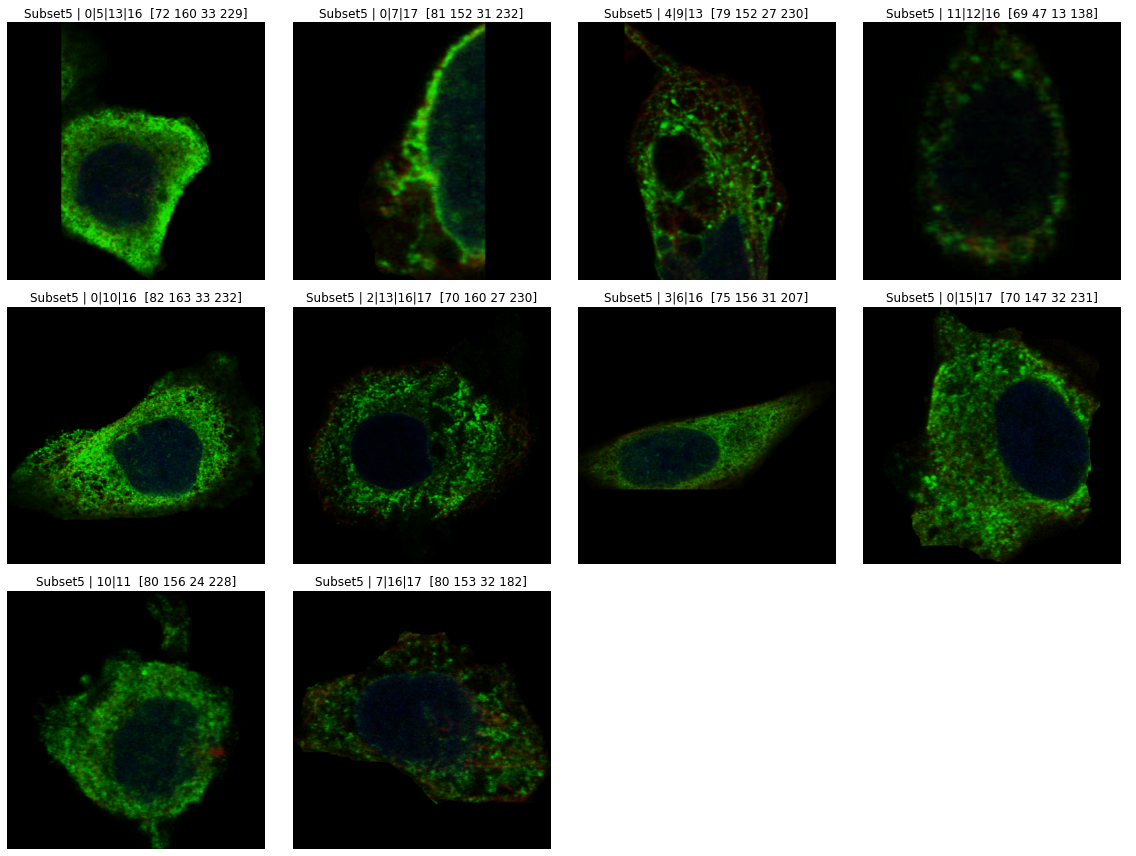

In [12]:
ncols = 4

nrows = (nsample - 1) // ncols + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')
for ax, (_, r) in zip(axs, df.iterrows()):
    dir_img = (dir_data
               /f'humanpro-train-cells-subset{r.subset}'
               /f'humanpro_train_cells_subset{r.subset}'/'train'/'images_384')
    img = load_RGBY_image(dir_img, r.Id)
    ax.imshow(img[...,[0,3,2]])
    ax.set_title(f"Subset{r.subset} | {r.Target}  {r[['max_red', 'max_green', 'max_blue', 'max_yellow']].values}")
    
plt.tight_layout()

In [13]:
del df

## Filter samples

In [14]:
df_cells = pd.read_feather(dir_mdata/'raw'/'train.feather')

In [15]:
len(df_cells)

36033

In [16]:
# For testing, just take a few samples
n_sample = len(df_cells)  

df_cells = df_cells.sample(n_sample).reset_index(drop=True)

In [17]:
df_cells.to_feather(dir_mdata_raw/'train.feather')

## One-hot encode labels

In [18]:
%%time
generate_meta(dir_mdata, 'train.feather')

CPU times: user 14.4 s, sys: 114 ms, total: 14.5 s
Wall time: 14.5 s


## Dataset, DataLoader

In [19]:
img_size = 384
crop_size = 256 
batch_size = 64
workers = 3
pin_memory = True
valid_file = Path(dir_mdata/'meta'/'train_meta.feather')
in_channels = 4

In [20]:
assert valid_file.exists()
    
valid_dataset = ProteinDataset(dir_data, valid_file, img_size=img_size, is_trainset=True,
                               return_label=True, in_channels=in_channels, transform=None,
                               crop_size=crop_size, random_crop=False)
    
valid_loader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset),
                          batch_size=batch_size, drop_last=False, 
                          num_workers=workers, pin_memory=pin_memory)

# Model

In [21]:
arch = 'class_densenet121_dropout'
num_classes = len(LABEL_NAME_LIST)
resume = Path('/kaggle/input/humanpro-classifier-crop/results/models/'
              'external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/'
              'fold0/final.pth')

model_params = {}
model_params['architecture'] = arch
model_params['num_classes'] = num_classes
model_params['in_channels'] = in_channels
model = init_network(model_params)

model = DataParallel(model)
model.to(DEVICE)

checkpoint = torch.load(resume)
model.module.load_state_dict(checkpoint['state_dict'])

>> Using pre-trained model.


<All keys matched successfully>

# Loss

In [22]:
criterion = FocalSymmetricLovaszHardLogLoss().to(DEVICE)
focal_loss = FocalLoss().to(DEVICE)

# Predict

In [23]:
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import f1_score

def validate(valid_loader, model, criterion, epoch, focal_loss, threshold=0.5):
    batch_time = AverageMeter()
    losses = AverageMeter()
    accuracy = AverageMeter()

    # switch to evaluate mode
    model.eval()

    probs_list = []
    labels_list = []
    logits_list = []
    loss_list = []
    acc_list = []

    end = time.time()
    for it, iter_data in tqdm(enumerate(valid_loader, 0)):
        images, labels, indices = iter_data
        images = Variable(images.to(DEVICE))
        labels = Variable(labels.to(DEVICE))

        outputs = model(images)
        loss = criterion(outputs, labels, epoch=epoch)

        logits = outputs
        probs = F.sigmoid(logits)
        acc = multi_class_acc(probs, labels)

        probs_list.append(probs.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        logits_list.append(logits.cpu().detach().numpy())
        loss_list.append(loss.item())
        acc_list.append(acc.item())

        losses.update(loss.item())
        accuracy.update(acc.item())

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    probs = np.vstack(probs_list)
    y_true = np.vstack(labels_list)
    logits = np.vstack(logits_list)
    loss = np.vstack(loss_list)
    acc = np.vstack(acc_list)
    valid_focal_loss = focal_loss.forward(torch.from_numpy(logits), torch.from_numpy(y_true))

    y_pred = probs > threshold
    kaggle_score = f1_score(y_true, y_pred, average='macro')

#     return losses.avg, accuracy.avg, valid_focal_loss, kaggle_score
    return losses.avg, accuracy.avg, valid_focal_loss, kaggle_score, probs, y_true, logits, loss, acc

In [24]:
%%time 

with torch.no_grad():
    (valid_loss, valid_acc, valid_focal_loss, kaggle_score, 
     probs, y_true, logits, loss, acc) = validate(valid_loader, model, criterion, 0, focal_loss)

564it [08:27,  1.11it/s]


CPU times: user 1min 17s, sys: 25.4 s, total: 1min 42s
Wall time: 8min 28s


In [25]:
36033 / 10 * 2.06 / 60**2

2.0618883333333335

## Plot predicted probabilities

In [26]:
def plt_prob_target(prob, target):
    '''
    Red inidicates the image-level labels
    '''
    class_id = np.arange(len(prob))
    prob_target = np.zeros_like(prob)
    prob_target[target==1] = prob[target==1].copy()
    prob_others = prob.copy()
    prob_others[target==1] = 0
    
    fig, ax = plt.subplots()
    ax.bar(class_id, prob_others)
    ax.bar(class_id, prob_target, color='red')
    ax.set_ylabel('Probability')
    ax.set_xlabel('Class')
    ax.set_title(f'Target {np.where(target==1)[0]}')
    return fig, ax

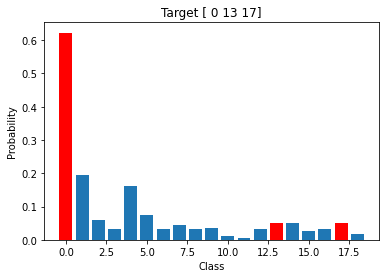

In [27]:
idx = 8
fig, ax = plt_prob_target(probs[idx], y_true[idx])

In [28]:
def get_softlabels(probs, y_true, keep_neg=False):
    labels = probs.copy()
    labels[y_true != 1] = 0
    if keep_neg:
        labels[:,-1] = probs[:,-1].copy()
    return labels

# Write out softlabels

In [29]:
softlabels = get_softlabels(probs, y_true)

In [30]:
df_cells_softlabel_subset5 = df_cells.copy()
df_cells_softlabel_subset5[LABEL_NAME_LIST] = softlabels

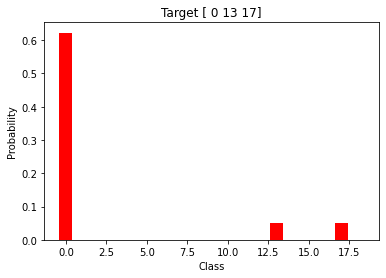

In [31]:
idx = 8
fig, ax = plt_prob_target(softlabels[idx], y_true[idx])

In [32]:
df_cells_softlabel_subset5.iloc[8]

Id                                                                               1208_A12_1_4
rle                                         {'counts': b'mWVk34lo12N1O1O4L1O2M?A101O1O2M10...
bbox                                                           [1971.0, 122.0, 2048.0, 366.0]
Target                                                                                0|13|17
max_green                                                                                 137
subset                                                                                      5
max_red                                                                                    72
max_blue                                                                                   20
max_yellow                                                                                230
Nucleoplasm                                                                          0.622354
Nuclear membrane                                            

In [33]:
df_cells_softlabel = pd.read_feather('/kaggle/input/humanpro-data-soft-pseudolabel/df_cells_softlabel.feather')
# "13|13" were mis-identified as multi-labels before, so these need to be removed.
df_cells_softlabel['Target'] = df_cells_softlabel.Target.apply(sort_target_labels)
df_cells_softlabel_sgl, df_cells_softlabel_mul = seperate_single_multi_labels(df_cells_softlabel)

df_cells_softlabel = pd.concat([df_cells_softlabel_mul, df_cells_softlabel_subset5], axis=0, ignore_index=True)

In [34]:
df_cells_softlabel.subset.unique(), df_cells_softlabel_mul.shape, df_cells_softlabel_subset5.shape, df_cells_softlabel.shape, df_orig_mul.shape

(array([2, 0, 1, 3, 4, 5]),
 (239784, 28),
 (36033, 28),
 (275817, 28),
 (275817, 9))

In [35]:
df_cells_softlabel.to_feather('/kaggle/working/df_cells_softlabel.feather')

# Write out softlabels with `Negative` always non-zero

In [36]:
softlabels_neg = get_softlabels(probs, y_true, keep_neg=True)

In [37]:
df_cells_softlabel_neg_subset5 = df_cells.copy()
df_cells_softlabel_neg_subset5[LABEL_NAME_LIST] = softlabels_neg

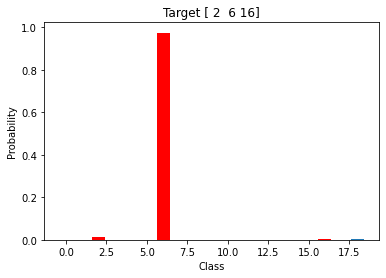

In [38]:
idx = 3
fig, ax = plt_prob_target(softlabels_neg[idx], y_true[idx])

In [39]:
df_cells_softlabel_neg_subset5.iloc[3]

Id                                                                                997_A8_2_15
rle                                         {'counts': b'nogn12ko13M3O10000001OO10000O1O1N...
bbox                                                         [1003.0, 1748.0, 1605.0, 2048.0]
Target                                                                                 2|6|16
max_green                                                                                 158
subset                                                                                      5
max_red                                                                                    70
max_blue                                                                                   28
max_yellow                                                                                209
Nucleoplasm                                                                                 0
Nuclear membrane                                            

In [40]:
df_cells_softlabel_neg = pd.read_feather('/kaggle/input/humanpro-data-soft-pseudolabel/df_cells_softlabel_neg.feather')
# Targets like "13|13" were mis-identified as multi-labels before, so these need to be removed.
df_cells_softlabel_neg['Target'] = df_cells_softlabel_neg.Target.apply(sort_target_labels)
df_cells_softlabel_neg_sgl, df_cells_softlabel_neg_mul = seperate_single_multi_labels(df_cells_softlabel_neg)

df_cells_softlabel_neg = pd.concat([df_cells_softlabel_neg_mul, df_cells_softlabel_neg_subset5], axis=0, ignore_index=True)

In [41]:
df_cells_softlabel_neg.subset.unique(), df_cells_softlabel_neg_mul.shape, df_cells_softlabel_neg_subset5.shape, df_cells_softlabel_neg.shape, df_orig_mul.shape

(array([2, 0, 1, 3, 4, 5]),
 (239784, 28),
 (36033, 28),
 (275817, 28),
 (275817, 9))

In [42]:
df_cells_softlabel_neg.to_feather('/kaggle/working/df_cells_softlabel_neg.feather')